### Notes - Data Preprocessing 
This textbook is a collection of data preprocessing techniques for machine learning applications gathered from the 'Hands On Machine Learning with Scikit-Learn, Keras and Tensorflow' by Aurelion Geron for purely educational purposes.

The dataset used as an example here is housing.csv found in the datasets directory.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset = pd.read_csv("../datasets/housing.csv")

- Creating the train and test sets

These two need to be separated, as one will serve to do the training and the other to do the evaluation. If they were together, a bias could be created. Look into _Data Snooping Bias_.

In [3]:
def split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(dataset))
    div = int(len(dataset) * test_ratio)
    test_indices = shuffled_indices[:div]
    train_indices = shuffled_indices[div:]
    return dataset.iloc[train_indices], dataset.iloc[test_indices]

train_set, test_set = split_train_test(dataset, 0.2)

print("Length of train and test sets:", len(train_set), len(test_set))

Length of train and test sets: 16512 4128


Alternatively, scikit-learn's train_test_split can be used.

In [4]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)
print(len(train_set), len(test_set))

16512 4128


- Making sure the test site is representative of the whole

For an important attribute especially, it's vital that the test set is representative of the whole distribution of said attribute. This is called _stratified sampling_ and it is used to avoid sampling biases.

First, you'll check the distribution of the "median_income" attribute.

<AxesSubplot:>

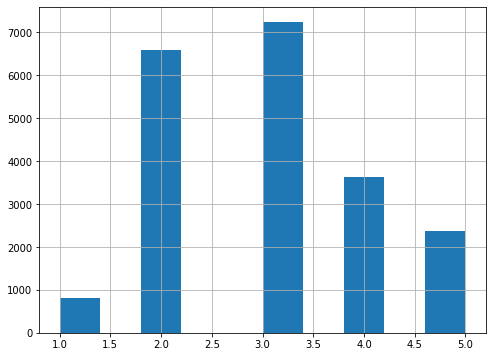

In [5]:
dataset['income_cat'] = pd.cut(dataset['median_income'],
                                bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                labels=[1, 2, 3, 4, 5])

dataset['income_cat'].hist(figsize=(8, 6))

You are now ready to apply stratified sampling to the test set.

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in shuffle_split.split(dataset, dataset['income_cat']):
    strat_train_set = dataset.iloc[train_index]
    strat_test_set = dataset.iloc[test_index]

strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

Remember to remove the "income_cat" attribute so that the data returns to normal.

In [7]:
for strat in (strat_test_set, strat_train_set):
    strat.drop("income_cat", axis=1, inplace=True)

/home/arthurscarpatto/.local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Notes - Data Visualization

- Visualizing the geographical data

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

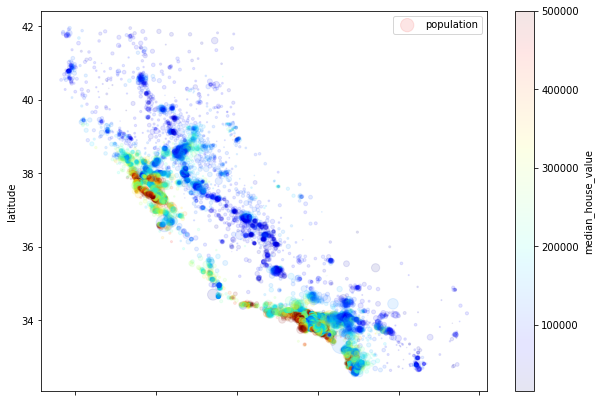

In [8]:
dataset.plot(kind="scatter", x="longitude", y="latitude",
             alpha=0.1, s=dataset["population"]/100, label="population",
             figsize=(10, 7), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

- Correlation Matrix

Good for checking what attributes are more impactful, whether by positive or negative correlations.

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

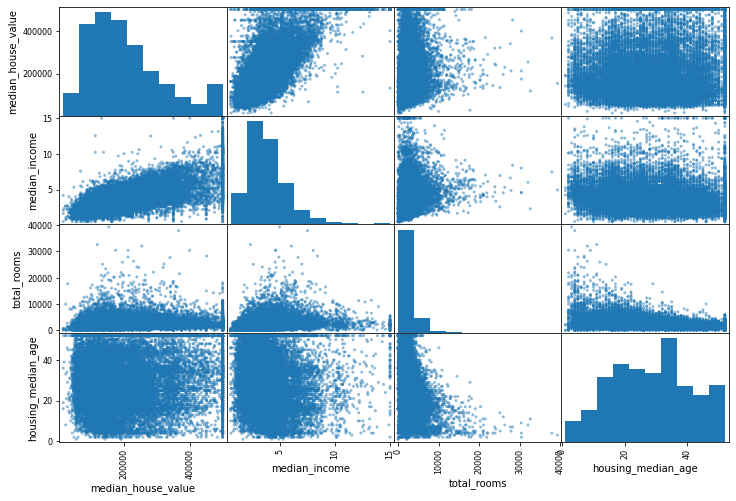

In [9]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(dataset[attributes], figsize=(12, 8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

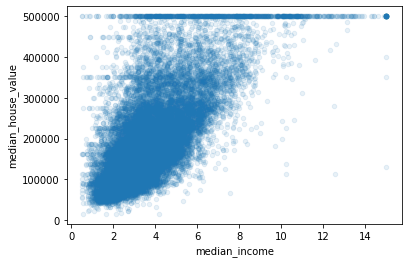

In [10]:
dataset.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

In [11]:
dataset['rooms_per_household'] = dataset['total_rooms'] / dataset['households']
dataset['bedrooms_per_room'] = dataset['total_bedrooms'] / dataset['total_rooms']
dataset['population_per_household'] = dataset['population'] / dataset['households']

corr_matrix = dataset.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

- Cleaning the data

In [12]:
dataset = strat_train_set.drop("median_house_value", axis=1)
dataset_labels = strat_train_set['median_house_value'].copy()

Both of the options below work well.

In [13]:
median = dataset['total_bedrooms'].median()
dataset['total_bedrooms'].fillna(median, inplace=True)

In [14]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

# imputer only works on numeric attributes
dataset_numeric = dataset.drop(['ocean_proximity'], axis=1)
imputer.fit(dataset_numeric)
X = imputer.transform(dataset_numeric)
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [15]:
# putting the X of the above cell back into the dataset
dataset_transformed = pd.DataFrame(X, columns=dataset_numeric.columns,
                        index=dataset_numeric.index)
dataset_transformed.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


- Manipulating Text and Categorical Data

In [16]:
dataset_cat = dataset[['ocean_proximity']]
dataset_cat.head()

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN


In [17]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
dataset_cat_encoded = ordinal_encoder.fit_transform(dataset_cat)
dataset_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [18]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
dataset_cat_1hot = encoder.fit_transform(dataset_cat)
dataset_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

- Making Custom Transformers

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, rooms_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(False)
housing_extra_attrs = attr_adder.transform(dataset.values)
housing_extra_attrs

array([[-121.46, 38.52, 29.0, ..., 'INLAND', 5.485835694050992,
        0.5775884327394785],
       [-117.23, 33.09, 7.0, ..., 'NEAR OCEAN', 6.927083333333333,
        0.37875939849624063],
       [-119.04, 35.37, 44.0, ..., 'INLAND', 5.3933333333333335,
        0.4122373300370828],
       ...,
       [-122.72, 38.44, 48.0, ..., '<1H OCEAN', 4.1104651162790695,
        0.6478076379066479],
       [-122.7, 38.31, 14.0, ..., '<1H OCEAN', 6.297405189620759,
        0.38288431061806655],
       [-122.14, 39.97, 27.0, ..., 'INLAND', 5.477157360406092,
        0.5792400370713624]], dtype=object)

- Pipeline Transformation


In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attrs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

dataset_num_transform = num_pipeline.fit_transform(dataset_numeric)

In [26]:
from sklearn.compose import ColumnTransformer

num_attrs = list(dataset_numeric)
cat_attrs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attrs),
    ("cat", OneHotEncoder(), cat_attrs)
])

full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('attrs_adder',
                                                  CombinedAttributesAdder()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('cat', OneHotEncoder(), ['ocean_proximity'])])